# Bayesian Models

1. Bayesian Neural Network
2. Monte Carlo Dropout
3. Deep Ensemble

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

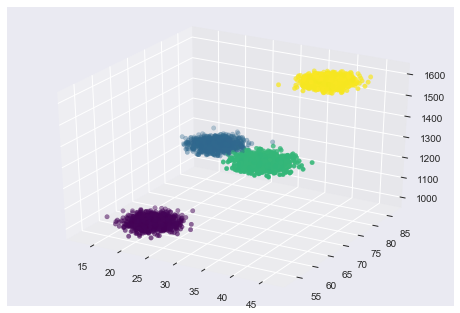

In [2]:
from data.synthetic import get_normal_data, plot_data

X, y = get_normal_data(1000)
plot_data(X, y)

# Variational Bayes

Bayesian Neural Network using Variational Inference

Ref:
* Flipout: Efficient Pseudo-Independent Weight Perturbations on Mini-Batches: https://arxiv.org/abs/1803.04386
* https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf
* https://github.com/krasserm/bayesian-machine-learning/blob/master/bayesian_neural_networks.ipynb
* https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py

In [8]:
class BayesNN:
    """Bayesian neural network using Flipout estimator"""
    def __init__(self, x_features, y_features, n_hidden=32, n_layers=3):
        self.x_features = x_features
        self.y_features = y_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss = lambda y, distr: -distr.log_prob(y)
        self.normal_sp = lambda params: tfd.Normal(
            loc=params[:,0:1],
            scale=1e-3+tf.math.softplus(0.05*params[:,1:2]))
        self.bias_posterior_fn = tfp.layers.util.default_mean_field_normal_fn()
        self.bias_prior_fn = tfp.layers.default_multivariate_normal_fn
        
    def kernel_divergence_fn(self, n_samples):
        return lambda q, p, _: tfp.distributions.kl_divergence(q, p) / n_samples
    
    def bias_divergence_fn(self, n_samples):
        return lambda q, p, _: tfp.distributions.kl_divergence(q, p) / n_samples
        
    def build_model(self, n_samples):
        self.model = tf.keras.Sequential([])
        for _ in range(self.n_layers):
            self.model.add(
                tfp.layers.DenseFlipout(self.n_hidden,
                    bias_posterior_fn=self.bias_posterior_fn,
                    bias_prior_fn=self.bias_prior_fn,
                    kernel_divergence_fn=self.kernel_divergence_fn(n_samples),
                    bias_divergence_fn=self.bias_divergence_fn(n_samples),
                    activation="relu"))
        self.model.add(tfp.layers.DistributionLambda(self.normal_sp))
        self.model.compile(self.optimizer, self.loss)
    
    def fit(self, X, y, epochs=1000, batch_size=32, verbose=1):
        self.build_model(n_samples=X.shape[0])
        return self.model.fit(X, y,
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=verbose)
    
    def sample(self, X):
        return self.model.predict(X)

In [9]:
bnn = BayesNN(x_features=2, y_features=1, n_hidden=32, n_layers=3)
bnn.fit(X, y, epochs=1000)

Epoch 1/1000
Instructions for updating:
Please use `layer.add_weight` method instead.
125/125 [==============================] - 0s 2ms/step - loss: 722502.8750
Epoch 2/1000
125/125 [==============================] - ETA: 0s - loss: 36412.894 - 0s 1ms/step - loss: 34312.3086
Epoch 3/1000
125/125 [==============================] - 0s 1ms/step - loss: 7884.3530
Epoch 4/1000
125/125 [==============================] - ETA: 0s - loss: 2254.29 - 0s 1ms/step - loss: 2166.0759
Epoch 5/1000
125/125 [==============================] - 0s 1ms/step - loss: 947.3445
Epoch 6/1000
125/125 [==============================] - 0s 1ms/step - loss: 506.4504
Epoch 7/1000
125/125 [==============================] - 0s 1ms/step - loss: 291.0865
Epoch 8/1000
125/125 [==============================] - ETA: 0s - loss: 165.916 - 0s 1ms/step - loss: 161.0657
Epoch 9/1000
125/125 [==============================] - 0s 2ms/step - loss: 84.3314
Epoch 10/1000
125/125 [==============================] - 0s 1ms/step - loss:

125/125 [==============================] - 0s 1ms/step - loss: 6.2025
Epoch 94/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1940
Epoch 95/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1960
Epoch 96/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1902
Epoch 97/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1830
Epoch 98/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1830
Epoch 99/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1860
Epoch 100/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1346
Epoch 101/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1412
Epoch 102/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1546
Epoch 103/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1434
Epoch 104/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1385
E

125/125 [==============================] - 0s 2ms/step - loss: 5.7220
Epoch 190/1000
125/125 [==============================] - 0s 2ms/step - loss: 5.7135
Epoch 191/1000
125/125 [==============================] - 1s 8ms/step - loss: 5.7127
Epoch 192/1000
125/125 [==============================] - 1s 6ms/step - loss: 5.7117
Epoch 193/1000
125/125 [==============================] - 1s 6ms/step - loss: 5.6948
Epoch 194/1000
125/125 [==============================] - 1s 7ms/step - loss: 5.6876
Epoch 195/1000
125/125 [==============================] - 1s 5ms/step - loss: 5.6679
Epoch 196/1000
125/125 [==============================] - 0s 4ms/step - loss: 5.6799
Epoch 197/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.6676
Epoch 198/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.6589
Epoch 199/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.6630
Epoch 200/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.

125/125 [==============================] - 0s 1ms/step - loss: 5.3267
Epoch 285/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.3198
Epoch 286/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.3237
Epoch 287/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.3092
Epoch 288/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.3202
Epoch 289/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.3246
Epoch 290/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.3028
Epoch 291/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2958
Epoch 292/1000
125/125 [==============================] - ETA: 0s - loss: 5.309 - 0s 1ms/step - loss: 5.3072
Epoch 293/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.3049
Epoch 294/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.3053
Epoch 295/1000
125/125 [==============================] 

125/125 [==============================] - 0s 1ms/step - loss: 5.2182
Epoch 381/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2195
Epoch 382/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2098
Epoch 383/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2109
Epoch 384/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2029
Epoch 385/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2151
Epoch 386/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2051
Epoch 387/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2081
Epoch 388/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2061
Epoch 389/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.2074
Epoch 390/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.1999
Epoch 391/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.

Epoch 476/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0974
Epoch 477/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0763
Epoch 478/1000
125/125 [==============================] - 0s 2ms/step - loss: 5.0841
Epoch 479/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0684
Epoch 480/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0822
Epoch 481/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0731
Epoch 482/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0692
Epoch 483/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0789
Epoch 484/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0632
Epoch 485/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0614
Epoch 486/1000
125/125 [==============================] - 0s 1ms/step - loss: 5.0588
Epoch 487/1000
125/125 [==============================] - 0s 1ms/

125/125 [==============================] - 0s 1ms/step - loss: 4.9709
Epoch 572/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9685
Epoch 573/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9723
Epoch 574/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9846
Epoch 575/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9746
Epoch 576/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9739
Epoch 577/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9644
Epoch 578/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9659
Epoch 579/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9690
Epoch 580/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9759
Epoch 581/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9620
Epoch 582/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.

125/125 [==============================] - 0s 1ms/step - loss: 4.9443
Epoch 668/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9293
Epoch 669/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9314
Epoch 670/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9286
Epoch 671/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9417
Epoch 672/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9224
Epoch 673/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9383
Epoch 674/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9341
Epoch 675/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9365
Epoch 676/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9355
Epoch 677/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9435
Epoch 678/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.

125/125 [==============================] - 0s 1ms/step - loss: 4.9042
Epoch 763/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9000
Epoch 764/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8950
Epoch 765/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8902
Epoch 766/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9045
Epoch 767/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8918
Epoch 768/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9013
Epoch 769/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.9023
Epoch 770/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8922
Epoch 771/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8978
Epoch 772/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8934
Epoch 773/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.

125/125 [==============================] - 0s 1ms/step - loss: 4.8476
Epoch 859/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8492
Epoch 860/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8510
Epoch 861/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8404
Epoch 862/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8969
Epoch 863/1000
125/125 [==============================] - 0s 2ms/step - loss: 4.8457
Epoch 864/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8496
Epoch 865/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8422
Epoch 866/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8423
Epoch 867/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.8292
Epoch 868/1000
125/125 [==============================] - 0s 2ms/step - loss: 4.8362
Epoch 869/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.

125/125 [==============================] - 0s 1ms/step - loss: 4.7872
Epoch 954/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7977
Epoch 955/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7919
Epoch 956/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7935
Epoch 957/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7778
Epoch 958/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7808
Epoch 959/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7708
Epoch 960/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7862
Epoch 961/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7774
Epoch 962/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7887
Epoch 963/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.7848
Epoch 964/1000
125/125 [==============================] - 0s 1ms/step - loss: 4.

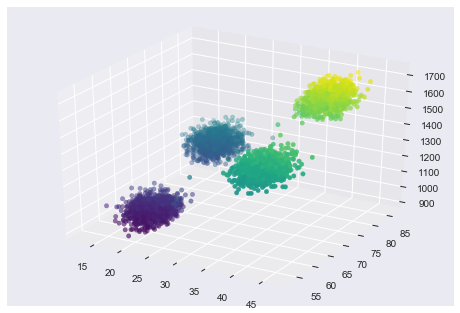

In [19]:
y_hat = bnn.sample(X)
plot_data(X, y_hat)

In [20]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=10)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.5174200856430837
rKL: -0.30201007975166805
JS: 0.026543764553313504


# Monte Carlo Dropout

Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning: https://arxiv.org/abs/1506.02142

Dropout is commonly used to prevent deep learning models from overfitting, by randomly zeroing-out activations during training and scale activations by p during testing. Dropout with some modifications is useful for estimating uncertainty of the model during prediction. Monte Carlo Dropout combines predictions of multiple forward passes of the same data point X through the network while applying different dropout masks. MC Dropout applies dropout both during training and testing.

1. Train a neural network f_θ(x) containing Dropout layers and an appropriate probabilistic loss.
2. During testing, perform T stochastic forward passes through f_θ(x) to obtain predictions for input x.
3. Combine predictions to obtain an expectation-based prediction and uncertainty estimate.

Ref:
* https://everyhue.me/posts/why-uncertainty-matters/
* https://github.com/huyng/incertae/blob/master/mcdrop_regression.ipynb

In [11]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Sequential


class MCDropout:
    def __init__(self, x_features, y_features, n_hidden=32, dropout=0.5):
        self.x_features = x_features
        self.y_features = y_features
        self.n_hidden = n_hidden
        self.dropout = dropout
        self.model = self.build_model()
    
    def build_model(self):
        model = Sequential([
            Dense(self.n_hidden, activation='relu'),
            Dense(self.n_hidden, activation='tanh'),
            Dropout(self.dropout),
            Dense(self.y_features + 1, activation=None),
        ])
        optimizer = tf.keras.optimizers.Adam()
        model.compile(loss=self.loss, optimizer=optimizer)
        return model
    
    def loss(self, y_true, y_pred):
        """Gaussian negative log likelihood.
            -log p(y|x) = log(sigma^2)/2 + (y-mu)^2/2sigma^2
        Model predits log(sigma^2) rather than sigma^2 for stability."""
        y_true = tf.reshape(y_true, [-1])
        mu = y_pred[:, :-1]
        si = y_pred[:, -1][:,np.newaxis]
        loss = (si + tf.square(y_true - mu)/tf.math.exp(si)) / 2.0
        return tf.reduce_mean(loss)
    
    def fit(self, X, y, epochs=1000, verbose=1):
        self.model.fit(X, y, batch_size=32, epochs=epochs, verbose=verbose)
        
    def predict(self, X, T=20):
        """Perform T stochastic forward passes."""
        mus, sigmas = [], []
        for t in range(T):
            print(f"Performing forward pass {t}/{T}")
            y_hat = self.model(X, training=True)
            mu, sigma = y_hat[:,:-1], y_hat[:,-1][:, np.newaxis]
            mus.append(mu)
            sigmas.append(sigma)
        
        mus = np.array(mus)
        sigmas = np.array(sigmas)
        variances = np.exp(sigmas)
        
        y_mean = np.mean(mus, axis=0)
        y_std = np.sqrt(np.mean(variances + mus**2, axis=0) - y_mean**2)
        return y_mean, y_std

In [12]:
mcdropout = MCDropout(X.shape[1], y.shape[1], n_hidden=32, dropout=0.3)
mcdropout.fit(X, y, epochs=1000)
y_mean, y_std = mcdropout.predict(X, T=20)

Epoch 1/1000
125/125 [==============================] - 0s 963us/step - loss: 278249.5625
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 37518.2461
Epoch 3/1000
125/125 [==============================] - 0s 976us/step - loss: 29384.9453
Epoch 4/1000
125/125 [==============================] - 0s 993us/step - loss: 22399.2559 0s - loss: 24800.48
Epoch 5/1000
125/125 [==============================] - 0s 968us/step - loss: 17548.9648
Epoch 6/1000
125/125 [==============================] - 0s 1ms/step - loss: 13950.9434
Epoch 7/1000
125/125 [==============================] - 0s 993us/step - loss: 11422.2979
Epoch 8/1000
125/125 [==============================] - 0s 1ms/step - loss: 9578.2822
Epoch 9/1000
125/125 [==============================] - 0s 996us/step - loss: 8353.1553
Epoch 10/1000
125/125 [==============================] - 0s 1ms/step - loss: 6860.1221
Epoch 11/1000
125/125 [==============================] - 0s 1ms/step - loss: 6037.1182
Epoch 12/100

125/125 [==============================] - 0s 1ms/step - loss: 21.4123
Epoch 95/1000
125/125 [==============================] - 0s 963us/step - loss: 20.5839
Epoch 96/1000
125/125 [==============================] - 0s 955us/step - loss: 20.1300
Epoch 97/1000
125/125 [==============================] - 0s 968us/step - loss: 18.0889
Epoch 98/1000
125/125 [==============================] - 0s 1ms/step - loss: 16.9449
Epoch 99/1000
125/125 [==============================] - 0s 1ms/step - loss: 19.0111
Epoch 100/1000
125/125 [==============================] - 0s 1ms/step - loss: 17.3488
Epoch 101/1000
125/125 [==============================] - 0s 1ms/step - loss: 16.3104
Epoch 102/1000
125/125 [==============================] - 0s 1ms/step - loss: 16.1311
Epoch 103/1000
125/125 [==============================] - 0s 958us/step - loss: 15.5013
Epoch 104/1000
125/125 [==============================] - 0s 988us/step - loss: 15.0771
Epoch 105/1000
125/125 [==============================] - 0s 979

125/125 [==============================] - 0s 983us/step - loss: 8.5787
Epoch 189/1000
125/125 [==============================] - 0s 959us/step - loss: 8.5698
Epoch 190/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6305
Epoch 191/1000
125/125 [==============================] - 0s 996us/step - loss: 8.6248
Epoch 192/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.5359
Epoch 193/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.5856
Epoch 194/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.5821
Epoch 195/1000
125/125 [==============================] - 0s 961us/step - loss: 8.5600
Epoch 196/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6080
Epoch 197/1000
125/125 [==============================] - 0s 989us/step - loss: 8.5285
Epoch 198/1000
125/125 [==============================] - 0s 955us/step - loss: 8.6115
Epoch 199/1000
125/125 [==============================] - 0s 966us/s

125/125 [==============================] - 0s 1ms/step - loss: 7.9701
Epoch 284/1000
125/125 [==============================] - 0s 968us/step - loss: 7.9960
Epoch 285/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9521
Epoch 286/1000
125/125 [==============================] - 0s 968us/step - loss: 7.9717 0s - loss: 7.96
Epoch 287/1000
125/125 [==============================] - 0s 984us/step - loss: 7.9597
Epoch 288/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9328
Epoch 289/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9619
Epoch 290/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.8980
Epoch 291/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9390
Epoch 292/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.8902
Epoch 293/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9609
Epoch 294/1000
125/125 [==============================] - 

125/125 [==============================] - 0s 1ms/step - loss: 7.2467
Epoch 379/1000
125/125 [==============================] - 0s 968us/step - loss: 7.2329
Epoch 380/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2203
Epoch 381/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2038
Epoch 382/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2024
Epoch 383/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2024
Epoch 384/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.1879
Epoch 385/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.1738
Epoch 386/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.1618
Epoch 387/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.1696
Epoch 388/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.1581
Epoch 389/1000
125/125 [==============================] - 0s 1ms/step - loss: 

125/125 [==============================] - 0s 1ms/step - loss: 6.3771
Epoch 474/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3687
Epoch 475/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3623
Epoch 476/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3464
Epoch 477/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3344
Epoch 478/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3327
Epoch 479/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3226
Epoch 480/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3092
Epoch 481/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3070
Epoch 482/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.2964
Epoch 483/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.2855
Epoch 484/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - ETA: 0s - loss: 6.079 - 0s 989us/step - loss: 6.0790
Epoch 569/1000
125/125 [==============================] - 0s 981us/step - loss: 6.0834
Epoch 570/1000
125/125 [==============================] - 0s 976us/step - loss: 6.0853
Epoch 571/1000
125/125 [==============================] - 0s 992us/step - loss: 6.0836
Epoch 572/1000
125/125 [==============================] - 0s 996us/step - loss: 6.0822
Epoch 573/1000
125/125 [==============================] - 0s 965us/step - loss: 6.0797
Epoch 574/1000
125/125 [==============================] - 0s 939us/step - loss: 6.0828
Epoch 575/1000
125/125 [==============================] - 0s 984us/step - loss: 6.0859
Epoch 576/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0835
Epoch 577/1000
125/125 [==============================] - 0s 986us/step - loss: 6.0852
Epoch 578/1000
125/125 [==============================] - 0s 995us/step - loss: 6.0814 0s - loss: 6.083
Epoch 579/1000
125/

125/125 [==============================] - 0s 976us/step - loss: 6.0799
Epoch 663/1000
125/125 [==============================] - ETA: 0s - loss: 6.082 - 0s 968us/step - loss: 6.0807
Epoch 664/1000
125/125 [==============================] - 0s 944us/step - loss: 6.0824
Epoch 665/1000
125/125 [==============================] - 0s 944us/step - loss: 6.0826
Epoch 666/1000
125/125 [==============================] - 0s 952us/step - loss: 6.0819
Epoch 667/1000
125/125 [==============================] - 0s 944us/step - loss: 6.0783
Epoch 668/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0818
Epoch 669/1000
125/125 [==============================] - 0s 984us/step - loss: 6.0804
Epoch 670/1000
125/125 [==============================] - 0s 971us/step - loss: 6.0840
Epoch 671/1000
125/125 [==============================] - 0s 962us/step - loss: 6.0795
Epoch 672/1000
125/125 [==============================] - 0s 978us/step - loss: 6.0837
Epoch 673/1000
125/125 [==========

125/125 [==============================] - 0s 952us/step - loss: 6.0803
Epoch 757/1000
125/125 [==============================] - 0s 952us/step - loss: 6.0799
Epoch 758/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0781
Epoch 759/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0826
Epoch 760/1000
125/125 [==============================] - 0s 944us/step - loss: 6.0820
Epoch 761/1000
125/125 [==============================] - 0s 960us/step - loss: 6.0773
Epoch 762/1000
125/125 [==============================] - 0s 952us/step - loss: 6.0774
Epoch 763/1000
125/125 [==============================] - 0s 942us/step - loss: 6.0859
Epoch 764/1000
125/125 [==============================] - 0s 968us/step - loss: 6.0842
Epoch 765/1000
125/125 [==============================] - 0s 958us/step - loss: 6.0812
Epoch 766/1000
125/125 [==============================] - 0s 952us/step - loss: 6.0842
Epoch 767/1000
125/125 [==============================] - 0s

125/125 [==============================] - 0s 1ms/step - loss: 6.0810
Epoch 852/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0817
Epoch 853/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0817
Epoch 854/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0822
Epoch 855/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0784
Epoch 856/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0823
Epoch 857/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0741
Epoch 858/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0794
Epoch 859/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0774
Epoch 860/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0836
Epoch 861/1000
125/125 [==============================] - 0s 2ms/step - loss: 6.0857
Epoch 862/1000
125/125 [==============================] - 0s 980us/step - loss: 

125/125 [==============================] - 0s 1ms/step - loss: 6.0815
Epoch 947/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0812
Epoch 948/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0813
Epoch 949/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0814
Epoch 950/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0785
Epoch 951/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0726
Epoch 952/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0771
Epoch 953/1000
125/125 [==============================] - 0s 989us/step - loss: 6.0796
Epoch 954/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0770
Epoch 955/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0813
Epoch 956/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0758
Epoch 957/1000
125/125 [==============================] - 0s 1ms/step - loss: 

Performing forward pass 0/10
Performing forward pass 1/10
Performing forward pass 2/10
Performing forward pass 3/10
Performing forward pass 4/10
Performing forward pass 5/10
Performing forward pass 6/10
Performing forward pass 7/10
Performing forward pass 8/10
Performing forward pass 9/10


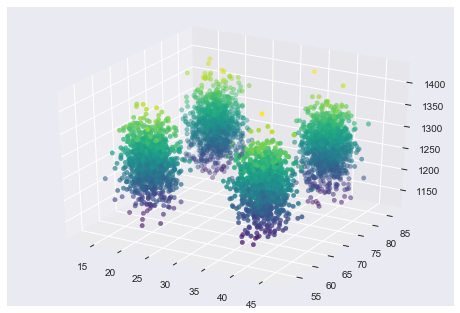

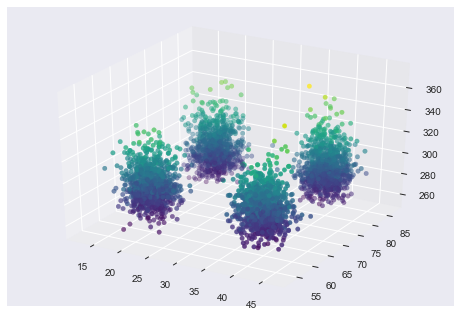

In [21]:
y_mean, y_std = mcdropout.predict(X, T=10)
plot_data(X, y_mean)
plot_data(X, y_std)

In [23]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_mean, bins=10)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.6482343485004264
rKL: -0.06622461812700906
JS: 0.0580643344638754


# Deep Ensemble

Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles: https://arxiv.org/abs/1612.01474

Deep Ensembles use M trained models initialised from random starting points to collect Monte Carlo samples.

Ref:
* https://github.com/huyng/incertae/blob/master/ensemble_regression.ipynb

In [15]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Sequential


class DeepEnsemble:
    def __init__(self, x_features, y_features, n_models=5, n_hidden=20, dropout=0.5):
        self.x_features = x_features
        self.y_features = y_features
        self.n_models = n_models
        self.n_hidden = n_hidden
        self.dropout = dropout
        self.models = [self.build_model() for _ in range(n_models)]
    
    def build_model(self):
        model = Sequential([
            Dense(self.n_hidden, activation='relu'),
            Dense(self.n_hidden, activation='tanh'),
            Dropout(self.dropout),
            Dense(self.y_features + 1, activation=None),
        ])
        optimizer = tf.keras.optimizers.Adam(0.001)
        model.compile(loss=self.loss, optimizer=optimizer)
        return model
    
    def loss(self, y_true, y_pred):
        """Gaussian negative log likelihood.
            -log p(y|x) = log(sigma^2)/2 + (y-mu)^2/2sigma^2
        Model predits log(sigma^2) rather than sigma^2 for stability."""
        
        y_true = tf.reshape(y_true, [-1])
        mu = y_pred[:, :-1]
        si = y_pred[:, -1][:,np.newaxis]
        loss = (si + tf.square(y_true - mu)/tf.math.exp(si)) / 2.0
        return tf.reduce_mean(loss)
    
    def fit(self, X, y, epochs=100, verbose=1):
        """TODO: Fit subset of data per model"""
        for i in range(len(self.models)):
            print(f"Training model {i+1}/{len(self.models)}")
            self.models[i].fit(X, y, batch_size=32, epochs=epochs, verbose=verbose)
        
    def predict(self, X):
        """Perform T stochastic forward passes."""
        
        mus, sigmas = [], []
        for t, model in enumerate(self.models):
            print(f"Performing forward pass {t+1}/{len(self.models)}")
            y_hat = model(X)
            mu, sigma = y_hat[:,:-1], y_hat[:,-1][:, np.newaxis]
            mus.append(mu)
            sigmas.append(sigma)  # TODO: check merging ensemble results for variance
            
        mus = np.array(mus)
        sigmas = np.array(sigmas)
        variances = np.exp(sigmas)
        
        y_mean = np.mean(mus, axis=0)
        y_variance = np.mean(variances + mus**2, axis=0) - y_mean**2
        y_std = np.sqrt(y_variance)
        return y_mean, y_std

In [16]:
deepensem = DeepEnsemble(X.shape[1], y.shape[1], n_models=5, n_hidden=32, dropout=0.3)
deepensem.fit(X, y, epochs=1000)

Training model 0/5
Epoch 1/1000
125/125 [==============================] - 0s 1ms/step - loss: 752775.6250
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 94633.1875
Epoch 3/1000
125/125 [==============================] - 0s 1ms/step - loss: 70958.8828
Epoch 4/1000
125/125 [==============================] - 0s 1ms/step - loss: 52874.9375
Epoch 5/1000
125/125 [==============================] - 0s 968us/step - loss: 42512.4336
Epoch 6/1000
125/125 [==============================] - 0s 1ms/step - loss: 33944.6523
Epoch 7/1000
125/125 [==============================] - 0s 1ms/step - loss: 27169.3633
Epoch 8/1000
125/125 [==============================] - 0s 1ms/step - loss: 21951.6621
Epoch 9/1000
125/125 [==============================] - 0s 1000us/step - loss: 19276.1426
Epoch 10/1000
125/125 [==============================] - 0s 1ms/step - loss: 16690.7695
Epoch 11/1000
125/125 [==============================] - 0s 1ms/step - loss: 14543.4473
Epoch 12/1000
12

125/125 [==============================] - 0s 952us/step - loss: 36.9857
Epoch 96/1000
125/125 [==============================] - 0s 944us/step - loss: 39.9770
Epoch 97/1000
125/125 [==============================] - 0s 954us/step - loss: 37.9278
Epoch 98/1000
125/125 [==============================] - 0s 1ms/step - loss: 36.6554
Epoch 99/1000
125/125 [==============================] - 0s 1ms/step - loss: 34.8799
Epoch 100/1000
125/125 [==============================] - 0s 1ms/step - loss: 29.6971
Epoch 101/1000
125/125 [==============================] - 0s 1ms/step - loss: 28.2312
Epoch 102/1000
125/125 [==============================] - 0s 1ms/step - loss: 28.6057
Epoch 103/1000
125/125 [==============================] - 0s 1ms/step - loss: 26.9840
Epoch 104/1000
125/125 [==============================] - 0s 1ms/step - loss: 26.5895
Epoch 105/1000
125/125 [==============================] - 0s 1ms/step - loss: 24.3728
Epoch 106/1000
125/125 [==============================] - 0s 1ms/st

125/125 [==============================] - 0s 984us/step - loss: 8.7770
Epoch 190/1000
125/125 [==============================] - 0s 968us/step - loss: 8.6473
Epoch 191/1000
125/125 [==============================] - 0s 944us/step - loss: 8.8632
Epoch 192/1000
125/125 [==============================] - 0s 992us/step - loss: 8.7222
Epoch 193/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.8252
Epoch 194/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.7639
Epoch 195/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6721
Epoch 196/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.7004
Epoch 197/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.7906
Epoch 198/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6676
Epoch 199/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6946
Epoch 200/1000
125/125 [==============================] - 0s 960us/step 

125/125 [==============================] - 0s 936us/step - loss: 8.0644
Epoch 285/1000
125/125 [==============================] - 0s 923us/step - loss: 8.0450
Epoch 286/1000
125/125 [==============================] - 0s 940us/step - loss: 8.0640
Epoch 287/1000
125/125 [==============================] - 0s 920us/step - loss: 8.0551
Epoch 288/1000
125/125 [==============================] - 0s 928us/step - loss: 8.0270
Epoch 289/1000
125/125 [==============================] - 0s 945us/step - loss: 8.0347
Epoch 290/1000
125/125 [==============================] - 0s 920us/step - loss: 8.0369
Epoch 291/1000
125/125 [==============================] - 0s 928us/step - loss: 8.0039
Epoch 292/1000
125/125 [==============================] - 0s 956us/step - loss: 8.0148
Epoch 293/1000
125/125 [==============================] - 0s 928us/step - loss: 8.0025
Epoch 294/1000
125/125 [==============================] - 0s 920us/step - loss: 8.0662
Epoch 295/1000
125/125 [==============================] - 

125/125 [==============================] - 0s 1ms/step - loss: 7.3568
Epoch 380/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.3441
Epoch 381/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.3290
Epoch 382/1000
125/125 [==============================] - 0s 950us/step - loss: 7.3362
Epoch 383/1000
125/125 [==============================] - 0s 952us/step - loss: 7.3224
Epoch 384/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2972
Epoch 385/1000
125/125 [==============================] - 0s 968us/step - loss: 7.3186
Epoch 386/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2919
Epoch 387/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2857
Epoch 388/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2870
Epoch 389/1000
125/125 [==============================] - 0s 992us/step - loss: 7.2609
Epoch 390/1000
125/125 [==============================] - 0s 992us/step 

125/125 [==============================] - 0s 942us/step - loss: 6.5246
Epoch 473/1000
125/125 [==============================] - 0s 949us/step - loss: 6.5138
Epoch 474/1000
125/125 [==============================] - 0s 936us/step - loss: 6.5016
Epoch 475/1000
125/125 [==============================] - 0s 958us/step - loss: 6.4864
Epoch 476/1000
125/125 [==============================] - 0s 945us/step - loss: 6.4857
Epoch 477/1000
125/125 [==============================] - 0s 957us/step - loss: 6.4820
Epoch 478/1000
125/125 [==============================] - 0s 936us/step - loss: 6.4581
Epoch 479/1000
125/125 [==============================] - 0s 938us/step - loss: 6.4542
Epoch 480/1000
125/125 [==============================] - 0s 934us/step - loss: 6.4404
Epoch 481/1000
125/125 [==============================] - 0s 928us/step - loss: 6.4340
Epoch 482/1000
125/125 [==============================] - 0s 944us/step - loss: 6.4355
Epoch 483/1000
125/125 [==============================] - 

125/125 [==============================] - 0s 945us/step - loss: 6.0924
Epoch 567/1000
125/125 [==============================] - 0s 960us/step - loss: 6.0848
Epoch 568/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0827
Epoch 569/1000
125/125 [==============================] - 0s 984us/step - loss: 6.0918
Epoch 570/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0852
Epoch 571/1000
125/125 [==============================] - 0s 966us/step - loss: 6.0837
Epoch 572/1000
125/125 [==============================] - 0s 952us/step - loss: 6.0832
Epoch 573/1000
125/125 [==============================] - 0s 944us/step - loss: 6.0807
Epoch 574/1000
125/125 [==============================] - 0s 929us/step - loss: 6.0832
Epoch 575/1000
125/125 [==============================] - 0s 950us/step - loss: 6.0878
Epoch 576/1000
125/125 [==============================] - 0s 938us/step - loss: 6.0827
Epoch 577/1000
125/125 [==============================] - 0s

125/125 [==============================] - 0s 992us/step - loss: 6.0812
Epoch 662/1000
125/125 [==============================] - 0s 968us/step - loss: 6.0784
Epoch 663/1000
125/125 [==============================] - 0s 960us/step - loss: 6.0802
Epoch 664/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0837
Epoch 665/1000
125/125 [==============================] - 0s 976us/step - loss: 6.0799
Epoch 666/1000
125/125 [==============================] - 0s 984us/step - loss: 6.0787
Epoch 667/1000
125/125 [==============================] - 0s 976us/step - loss: 6.0871
Epoch 668/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0819
Epoch 669/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0807
Epoch 670/1000
125/125 [==============================] - 0s 998us/step - loss: 6.0831
Epoch 671/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0831
Epoch 672/1000
125/125 [==============================] - 0s 9

Epoch 756/1000
125/125 [==============================] - 0s 960us/step - loss: 6.0759
Epoch 757/1000
125/125 [==============================] - 0s 960us/step - loss: 6.0832
Epoch 758/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0846
Epoch 759/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0773
Epoch 760/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0805
Epoch 761/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0831
Epoch 762/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0843
Epoch 763/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0844
Epoch 764/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0738
Epoch 765/1000
125/125 [==============================] - 0s 976us/step - loss: 6.0800
Epoch 766/1000
125/125 [==============================] - 0s 953us/step - loss: 6.0804
Epoch 767/1000
125/125 [==============================] -

125/125 [==============================] - 0s 960us/step - loss: 6.0781
Epoch 850/1000
125/125 [==============================] - 0s 976us/step - loss: 6.0806
Epoch 851/1000
125/125 [==============================] - 0s 952us/step - loss: 6.0863
Epoch 852/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0837
Epoch 853/1000
125/125 [==============================] - 0s 965us/step - loss: 6.0799
Epoch 854/1000
125/125 [==============================] - 0s 932us/step - loss: 6.0769
Epoch 855/1000
125/125 [==============================] - 0s 928us/step - loss: 6.0862
Epoch 856/1000
125/125 [==============================] - 0s 939us/step - loss: 6.0822
Epoch 857/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0760
Epoch 858/1000
125/125 [==============================] - 0s 937us/step - loss: 6.0826
Epoch 859/1000
125/125 [==============================] - 0s 942us/step - loss: 6.0802
Epoch 860/1000
125/125 [==============================] - 

125/125 [==============================] - 0s 944us/step - loss: 6.0783
Epoch 944/1000
125/125 [==============================] - 0s 933us/step - loss: 6.0801
Epoch 945/1000
125/125 [==============================] - 0s 952us/step - loss: 6.0775
Epoch 946/1000
125/125 [==============================] - 0s 920us/step - loss: 6.0765
Epoch 947/1000
125/125 [==============================] - 0s 944us/step - loss: 6.0799
Epoch 948/1000
125/125 [==============================] - 0s 945us/step - loss: 6.0869
Epoch 949/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0758
Epoch 950/1000
125/125 [==============================] - 0s 945us/step - loss: 6.0834
Epoch 951/1000
125/125 [==============================] - 0s 960us/step - loss: 6.0734
Epoch 952/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0843
Epoch 953/1000
125/125 [==============================] - 0s 936us/step - loss: 6.0767
Epoch 954/1000
125/125 [==============================] - 

125/125 [==============================] - 0s 1ms/step - loss: 723.8503
Epoch 37/1000
125/125 [==============================] - 0s 986us/step - loss: 705.6110
Epoch 38/1000
125/125 [==============================] - 0s 984us/step - loss: 651.8275
Epoch 39/1000
125/125 [==============================] - 0s 980us/step - loss: 596.5580
Epoch 40/1000
125/125 [==============================] - 0s 1000us/step - loss: 568.4686
Epoch 41/1000
125/125 [==============================] - 0s 1ms/step - loss: 510.6938
Epoch 42/1000
125/125 [==============================] - 0s 1ms/step - loss: 520.9965
Epoch 43/1000
125/125 [==============================] - 0s 1ms/step - loss: 491.2434
Epoch 44/1000
125/125 [==============================] - 0s 1ms/step - loss: 414.3422
Epoch 45/1000
125/125 [==============================] - 0s 1ms/step - loss: 424.7731
Epoch 46/1000
125/125 [==============================] - 0s 1ms/step - loss: 376.3902
Epoch 47/1000
125/125 [==============================] - 0s

125/125 [==============================] - 0s 1ms/step - loss: 9.6478
Epoch 132/1000
125/125 [==============================] - 0s 985us/step - loss: 9.6639
Epoch 133/1000
125/125 [==============================] - 0s 977us/step - loss: 9.1272
Epoch 134/1000
125/125 [==============================] - 0s 992us/step - loss: 9.6982
Epoch 135/1000
125/125 [==============================] - 0s 980us/step - loss: 9.4792
Epoch 136/1000
125/125 [==============================] - 0s 960us/step - loss: 9.7632
Epoch 137/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.5603
Epoch 138/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.2138
Epoch 139/1000
125/125 [==============================] - 0s 980us/step - loss: 9.3210
Epoch 140/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.2491
Epoch 141/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.4856
Epoch 142/1000
125/125 [==============================] - ETA: 0s - 

125/125 [==============================] - 0s 1ms/step - loss: 8.3513
Epoch 227/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3758
Epoch 228/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.4010
Epoch 229/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3178
Epoch 230/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3967
Epoch 231/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3186
Epoch 232/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3385
Epoch 233/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3376
Epoch 234/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.2894
Epoch 235/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3429
Epoch 236/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.2925
Epoch 237/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.

125/125 [==============================] - 0s 1ms/step - loss: 7.6991
Epoch 323/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6765
Epoch 324/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6659
Epoch 325/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6601
Epoch 326/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6674
Epoch 327/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6403
Epoch 328/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6331
Epoch 329/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6138
Epoch 330/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6266
Epoch 331/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6247
Epoch 332/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6115
Epoch 333/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.

125/125 [==============================] - 0s 1ms/step - loss: 6.9042
Epoch 418/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8930
Epoch 419/1000
125/125 [==============================] - 0s 987us/step - loss: 6.8834
Epoch 420/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8697
Epoch 421/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8608
Epoch 422/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8572
Epoch 423/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8533
Epoch 424/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8374
Epoch 425/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8290
Epoch 426/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8248
Epoch 427/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8097
Epoch 428/1000
125/125 [==============================] - 0s 1ms/step - loss: 

125/125 [==============================] - 0s 1ms/step - loss: 6.1180
Epoch 514/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1081
Epoch 515/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1116
Epoch 516/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1044
Epoch 517/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1114
Epoch 518/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1060
Epoch 519/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0944
Epoch 520/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1019
Epoch 521/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1016
Epoch 522/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1026
Epoch 523/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0959
Epoch 524/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 6.0784
Epoch 610/1000
125/125 [==============================] - 0s 1000us/step - loss: 6.0833
Epoch 611/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0794
Epoch 612/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0850
Epoch 613/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0810
Epoch 614/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0750
Epoch 615/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0740
Epoch 616/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0822
Epoch 617/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0841
Epoch 618/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0856
Epoch 619/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0787
Epoch 620/1000
125/125 [==============================] - 0s 1ms/step - loss:

125/125 [==============================] - 0s 1ms/step - loss: 6.0868
Epoch 706/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0889
Epoch 707/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0823
Epoch 708/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0824
Epoch 709/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0798
Epoch 710/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0826
Epoch 711/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0800
Epoch 712/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0776
Epoch 713/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0795
Epoch 714/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0835
Epoch 715/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0867
Epoch 716/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 6.0793
Epoch 802/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0832
Epoch 803/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0757
Epoch 804/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0850
Epoch 805/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0791
Epoch 806/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0803
Epoch 807/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0798
Epoch 808/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0803
Epoch 809/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0766
Epoch 810/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0817
Epoch 811/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0864
Epoch 812/1000
125/125 [==============================] - 0s 992us/step - loss: 

125/125 [==============================] - 0s 1ms/step - loss: 6.0776
Epoch 897/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0779
Epoch 898/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0799
Epoch 899/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0838
Epoch 900/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0794
Epoch 901/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0791
Epoch 902/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0822
Epoch 903/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0863
Epoch 904/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0848
Epoch 905/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0788
Epoch 906/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0816
Epoch 907/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 6.0758
Epoch 993/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0809
Epoch 994/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0765
Epoch 995/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0738
Epoch 996/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0786
Epoch 997/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0818
Epoch 998/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0731
Epoch 999/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0763
Epoch 1000/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0770
Training model 2/5
Epoch 1/1000
125/125 [==============================] - 0s 976us/step - loss: 289336.1250
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 15747.9883
Epoch 3/1000
125/125 [==============================]

Epoch 87/1000
125/125 [==============================] - 0s 1ms/step - loss: 28.7959
Epoch 88/1000
125/125 [==============================] - 0s 1ms/step - loss: 25.9439
Epoch 89/1000
125/125 [==============================] - 0s 1ms/step - loss: 25.5438
Epoch 90/1000
125/125 [==============================] - 0s 1ms/step - loss: 22.9390
Epoch 91/1000
125/125 [==============================] - 0s 1ms/step - loss: 23.6545
Epoch 92/1000
125/125 [==============================] - 0s 1ms/step - loss: 21.2118
Epoch 93/1000
125/125 [==============================] - 0s 1ms/step - loss: 19.8888
Epoch 94/1000
125/125 [==============================] - 0s 1ms/step - loss: 20.1281
Epoch 95/1000
125/125 [==============================] - 0s 1ms/step - loss: 19.1475
Epoch 96/1000
125/125 [==============================] - 0s 1ms/step - loss: 19.1108
Epoch 97/1000
125/125 [==============================] - 0s 1ms/step - loss: 19.2242
Epoch 98/1000
125/125 [==============================] - 0s 2ms/s

125/125 [==============================] - 0s 1ms/step - loss: 8.7430A: 0s - loss: 8.738
Epoch 182/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6344
Epoch 183/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.7482
Epoch 184/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6454
Epoch 185/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.7135
Epoch 186/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6075
Epoch 187/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.5731
Epoch 188/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6768
Epoch 189/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.5992
Epoch 190/1000
125/125 [==============================] - 0s 1000us/step - loss: 8.6262
Epoch 191/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.6838
Epoch 192/1000
125/125 [==============================] - 

125/125 [==============================] - 0s 1ms/step - loss: 8.0185
Epoch 278/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.0053
Epoch 279/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.0095
Epoch 280/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.0086
Epoch 281/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9885
Epoch 282/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9664
Epoch 283/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9757
Epoch 284/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9798
Epoch 285/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9800
Epoch 286/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9705
Epoch 287/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.9380
Epoch 288/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.

125/125 [==============================] - 0s 1ms/step - loss: 7.2690
Epoch 374/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2631
Epoch 375/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2601
Epoch 376/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2477
Epoch 377/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2331
Epoch 378/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2394
Epoch 379/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2211
Epoch 380/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2237
Epoch 381/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.2109
Epoch 382/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.1992
Epoch 383/1000
125/125 [==============================] - 0s 976us/step - loss: 7.1933
Epoch 384/1000
125/125 [==============================] - 0s 1ms/step - loss: 

125/125 [==============================] - 0s 952us/step - loss: 6.4175
Epoch 469/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.4059
Epoch 470/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.4100
Epoch 471/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3857
Epoch 472/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3748
Epoch 473/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3716
Epoch 474/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3552
Epoch 475/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3542
Epoch 476/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3410
Epoch 477/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3316
Epoch 478/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.3274
Epoch 479/1000
125/125 [==============================] - 0s 1ms/step - loss: 

125/125 [==============================] - 0s 1ms/step - loss: 6.0823
Epoch 565/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0787
Epoch 566/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0820
Epoch 567/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0786
Epoch 568/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0824
Epoch 569/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0848
Epoch 570/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0866
Epoch 571/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0787
Epoch 572/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0778
Epoch 573/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0765
Epoch 574/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0815
Epoch 575/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 6.0853
Epoch 660/1000
125/125 [==============================] - 0s 984us/step - loss: 6.0798
Epoch 661/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0853
Epoch 662/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0843
Epoch 663/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0777
Epoch 664/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0792
Epoch 665/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0847
Epoch 666/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0843
Epoch 667/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0831
Epoch 668/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0765
Epoch 669/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0841
Epoch 670/1000
125/125 [==============================] - 0s 981us/step - loss

125/125 [==============================] - 0s 1ms/step - loss: 6.0780
Epoch 755/1000
125/125 [==============================] - 0s 994us/step - loss: 6.0800
Epoch 756/1000
125/125 [==============================] - 0s 985us/step - loss: 6.0816
Epoch 757/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0791
Epoch 758/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0776
Epoch 759/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0813
Epoch 760/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0795
Epoch 761/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0822
Epoch 762/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0748
Epoch 763/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0742
Epoch 764/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0750
Epoch 765/1000
125/125 [==============================] - 0s 1ms/step - loss

125/125 [==============================] - 0s 1ms/step - loss: 6.0772
Epoch 850/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0796
Epoch 851/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0772
Epoch 852/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0798
Epoch 853/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0842
Epoch 854/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0818
Epoch 855/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0829
Epoch 856/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0811
Epoch 857/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0783
Epoch 858/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0746
Epoch 859/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0788
Epoch 860/1000
125/125 [==============================] - 0s 1000us/step - loss:

125/125 [==============================] - 0s 1ms/step - loss: 6.0784
Epoch 945/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0759
Epoch 946/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0766
Epoch 947/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0803
Epoch 948/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0751
Epoch 949/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0735
Epoch 950/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0751
Epoch 951/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0803
Epoch 952/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0800
Epoch 953/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0741
Epoch 954/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0765
Epoch 955/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 184.3273
Epoch 38/1000
125/125 [==============================] - 0s 969us/step - loss: 188.8102
Epoch 39/1000
125/125 [==============================] - 0s 1ms/step - loss: 166.8806
Epoch 40/1000
125/125 [==============================] - 0s 963us/step - loss: 156.9983
Epoch 41/1000
125/125 [==============================] - 0s 976us/step - loss: 148.1145
Epoch 42/1000
125/125 [==============================] - 0s 1ms/step - loss: 142.3060
Epoch 43/1000
125/125 [==============================] - 0s 967us/step - loss: 138.9742
Epoch 44/1000
125/125 [==============================] - 0s 995us/step - loss: 130.1931
Epoch 45/1000
125/125 [==============================] - 0s 1ms/step - loss: 114.9470
Epoch 46/1000
125/125 [==============================] - 0s 1ms/step - loss: 108.7726
Epoch 47/1000
125/125 [==============================] - 0s 994us/step - loss: 103.8682
Epoch 48/1000
125/125 [==============================] -

125/125 [==============================] - 0s 1ms/step - loss: 8.7662
Epoch 132/1000
125/125 [==============================] - 0s 971us/step - loss: 9.0212
Epoch 133/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.8355
Epoch 134/1000
125/125 [==============================] - 0s 952us/step - loss: 8.8758
Epoch 135/1000
125/125 [==============================] - 0s 980us/step - loss: 8.6815
Epoch 136/1000
125/125 [==============================] - 0s 1000us/step - loss: 8.7733
Epoch 137/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.7773
Epoch 138/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.8660
Epoch 139/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.9706
Epoch 140/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.7040
Epoch 141/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.8198
Epoch 142/1000
125/125 [==============================] - 0s 1ms/step -

125/125 [==============================] - 0s 949us/step - loss: 8.3892
Epoch 226/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3191
Epoch 227/1000
125/125 [==============================] - 0s 976us/step - loss: 8.2394
Epoch 228/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.2912
Epoch 229/1000
125/125 [==============================] - 0s 961us/step - loss: 8.2925
Epoch 230/1000
125/125 [==============================] - 0s 983us/step - loss: 8.3409
Epoch 231/1000
125/125 [==============================] - 0s 958us/step - loss: 8.2206
Epoch 232/1000
125/125 [==============================] - 0s 944us/step - loss: 8.2829
Epoch 233/1000
125/125 [==============================] - 0s 960us/step - loss: 8.2261
Epoch 234/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.2327
Epoch 235/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.2385
Epoch 236/1000
125/125 [==============================] - 0s 984us

125/125 [==============================] - 0s 984us/step - loss: 7.6082
Epoch 321/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6058
Epoch 322/1000
125/125 [==============================] - 0s 952us/step - loss: 7.6041
Epoch 323/1000
125/125 [==============================] - 0s 944us/step - loss: 7.6098
Epoch 324/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.6121
Epoch 325/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.5977
Epoch 326/1000
125/125 [==============================] - 0s 949us/step - loss: 7.5762
Epoch 327/1000
125/125 [==============================] - 0s 935us/step - loss: 7.5699
Epoch 328/1000
125/125 [==============================] - 0s 936us/step - loss: 7.5673
Epoch 329/1000
125/125 [==============================] - 0s 984us/step - loss: 7.5516
Epoch 330/1000
125/125 [==============================] - 0s 952us/step - loss: 7.5526
Epoch 331/1000
125/125 [==============================] - 0s 944

125/125 [==============================] - 0s 1ms/step - loss: 6.8360
Epoch 415/1000
125/125 [==============================] - 0s 968us/step - loss: 6.8203
Epoch 416/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8140
Epoch 417/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8030
Epoch 418/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.8028
Epoch 419/1000
125/125 [==============================] - 0s 992us/step - loss: 6.7840
Epoch 420/1000
125/125 [==============================] - 0s 968us/step - loss: 6.7794
Epoch 421/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.7672
Epoch 422/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.7622
Epoch 423/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.7514
Epoch 424/1000
125/125 [==============================] - 0s 976us/step - loss: 6.7503
Epoch 425/1000
125/125 [==============================] - 0s 1ms/step - 

125/125 [==============================] - 0s 1ms/step - loss: 6.0997
Epoch 509/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0974
Epoch 510/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1015
Epoch 511/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0918
Epoch 512/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0945
Epoch 513/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0969
Epoch 514/1000
125/125 [==============================] - 0s 1000us/step - loss: 6.0914
Epoch 515/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0947
Epoch 516/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0880
Epoch 517/1000
125/125 [==============================] - ETA: 0s - loss: 6.089 - 0s 1ms/step - loss: 6.0915
Epoch 518/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0896
Epoch 519/1000
125/125 [=============================

125/125 [==============================] - 0s 1000us/step - loss: 6.0848
Epoch 604/1000
125/125 [==============================] - 0s 984us/step - loss: 6.0773
Epoch 605/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0781
Epoch 606/1000
125/125 [==============================] - 0s 960us/step - loss: 6.0892
Epoch 607/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0784
Epoch 608/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0792
Epoch 609/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0798
Epoch 610/1000
125/125 [==============================] - 0s 983us/step - loss: 6.0826
Epoch 611/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0779
Epoch 612/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0822
Epoch 613/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0830
Epoch 614/1000
125/125 [==============================] - 0s 1ms/step -

125/125 [==============================] - 0s 1ms/step - loss: 6.0817
Epoch 699/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0842
Epoch 700/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0826
Epoch 701/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0800
Epoch 702/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0846
Epoch 703/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0833
Epoch 704/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0798
Epoch 705/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0796
Epoch 706/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0880
Epoch 707/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0792
Epoch 708/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0759
Epoch 709/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 6.0756
Epoch 794/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0832
Epoch 795/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0757
Epoch 796/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0808
Epoch 797/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0859
Epoch 798/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0756
Epoch 799/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0777
Epoch 800/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0801
Epoch 801/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0831
Epoch 802/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0806
Epoch 803/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0815
Epoch 804/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 6.0753
Epoch 889/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0801
Epoch 890/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0771
Epoch 891/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0841
Epoch 892/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0769
Epoch 893/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0785
Epoch 894/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0852
Epoch 895/1000
125/125 [==============================] - 0s 2ms/step - loss: 6.0848
Epoch 896/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0755
Epoch 897/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0774
Epoch 898/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0730
Epoch 899/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 6.0790
Epoch 985/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0751
Epoch 986/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0798
Epoch 987/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0796
Epoch 988/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0803
Epoch 989/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0785
Epoch 990/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0823
Epoch 991/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0791
Epoch 992/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0748
Epoch 993/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0796
Epoch 994/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0760
Epoch 995/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 10.3752
Epoch 80/1000
125/125 [==============================] - 0s 1ms/step - loss: 10.5941
Epoch 81/1000
125/125 [==============================] - ETA: 0s - loss: 10.21 - 0s 1ms/step - loss: 10.2641
Epoch 82/1000
125/125 [==============================] - 0s 1ms/step - loss: 10.1193
Epoch 83/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.8057
Epoch 84/1000
125/125 [==============================] - 0s 1ms/step - loss: 10.0015
Epoch 85/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.7873
Epoch 86/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.5664
Epoch 87/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.4978
Epoch 88/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.5065
Epoch 89/1000
125/125 [==============================] - 0s 1ms/step - loss: 9.2368
Epoch 90/1000
125/125 [==============================] - 0s 1

125/125 [==============================] - 0s 1ms/step - loss: 8.4437
Epoch 175/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3876
Epoch 176/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3966
Epoch 177/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.4923A: 0s - loss: 8.523
Epoch 178/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.4241
Epoch 179/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.4083
Epoch 180/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3969
Epoch 181/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3843
Epoch 182/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3244
Epoch 183/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.3732
Epoch 184/1000
125/125 [==============================] - 0s 1ms/step - loss: 8.4795
Epoch 185/1000
125/125 [==============================] - 0s 

125/125 [==============================] - 0s 1ms/step - loss: 7.8130
Epoch 269/1000
125/125 [==============================] - 0s 993us/step - loss: 7.8001
Epoch 270/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.7940
Epoch 271/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.8089A: 0s - loss: 7.831
Epoch 272/1000
125/125 [==============================] - 0s 992us/step - loss: 7.7734
Epoch 273/1000
125/125 [==============================] - 0s 991us/step - loss: 7.7451
Epoch 274/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.7563
Epoch 275/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.7676
Epoch 276/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.7441
Epoch 277/1000
125/125 [==============================] - 0s 974us/step - loss: 7.7450
Epoch 278/1000
125/125 [==============================] - 0s 1000us/step - loss: 7.7415
Epoch 279/1000
125/125 [==========================

125/125 [==============================] - 0s 1ms/step - loss: 7.0539
Epoch 363/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.0463
Epoch 364/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.0279
Epoch 365/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.0253
Epoch 366/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.0118
Epoch 367/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.0108
Epoch 368/1000
125/125 [==============================] - 0s 1ms/step - loss: 7.0026
Epoch 369/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.9793
Epoch 370/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.9824
Epoch 371/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.9743
Epoch 372/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.9538
Epoch 373/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.

125/125 [==============================] - 0s 1ms/step - loss: 6.1998
Epoch 458/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1905
Epoch 459/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1796
Epoch 460/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1760
Epoch 461/1000
125/125 [==============================] - 0s 992us/step - loss: 6.1753
Epoch 462/1000
125/125 [==============================] - 0s 1000us/step - loss: 6.1640
Epoch 463/1000
125/125 [==============================] - 0s 998us/step - loss: 6.1621
Epoch 464/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1505
Epoch 465/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1431A: 0s - loss: 6.148
Epoch 466/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1443
Epoch 467/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.1382
Epoch 468/1000
125/125 [==============================

125/125 [==============================] - 0s 1ms/step - loss: 6.0798
Epoch 553/1000
125/125 [==============================] - 0s 991us/step - loss: 6.0858
Epoch 554/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0789
Epoch 555/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0831
Epoch 556/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0827
Epoch 557/1000
125/125 [==============================] - 0s 994us/step - loss: 6.0874
Epoch 558/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0801
Epoch 559/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0801
Epoch 560/1000
125/125 [==============================] - 0s 992us/step - loss: 6.0802
Epoch 561/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0847
Epoch 562/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0794
Epoch 563/1000
125/125 [==============================] - 0s 1ms/step - lo

125/125 [==============================] - 0s 1ms/step - loss: 6.0807
Epoch 648/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0792
Epoch 649/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 650/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0716
Epoch 651/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0826
Epoch 652/1000
125/125 [==============================] - 0s 1000us/step - loss: 6.0812
Epoch 653/1000
125/125 [==============================] - 0s 998us/step - loss: 6.0815
Epoch 654/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0815
Epoch 655/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0808
Epoch 656/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0773
Epoch 657/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0784
Epoch 658/1000
125/125 [==============================] - 0s 1ms/step - los

125/125 [==============================] - 0s 1ms/step - loss: 6.0802
Epoch 743/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0787
Epoch 744/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0847
Epoch 745/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0803
Epoch 746/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0790
Epoch 747/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0792
Epoch 748/1000
125/125 [==============================] - 0s 982us/step - loss: 6.0855
Epoch 749/1000
125/125 [==============================] - 0s 995us/step - loss: 6.0845
Epoch 750/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0823A: 0s - loss: 6.07
Epoch 751/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0778
Epoch 752/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0815
Epoch 753/1000
125/125 [==============================] - 

125/125 [==============================] - 0s 1ms/step - loss: 6.0789
Epoch 838/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0779
Epoch 839/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0803
Epoch 840/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0780
Epoch 841/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0793
Epoch 842/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0804
Epoch 843/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0805
Epoch 844/1000
125/125 [==============================] - 0s 997us/step - loss: 6.0715
Epoch 845/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0765
Epoch 846/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0788
Epoch 847/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0746
Epoch 848/1000
125/125 [==============================] - 0s 1ms/step - loss: 

125/125 [==============================] - 0s 1ms/step - loss: 6.0816
Epoch 933/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0782
Epoch 934/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0850
Epoch 935/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0806
Epoch 936/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0796
Epoch 937/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0775
Epoch 938/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0807
Epoch 939/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0813
Epoch 940/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0877
Epoch 941/1000
125/125 [==============================] - 0s 1000us/step - loss: 6.0732
Epoch 942/1000
125/125 [==============================] - 0s 1ms/step - loss: 6.0781
Epoch 943/1000
125/125 [==============================] - 0s 1ms/step - loss:

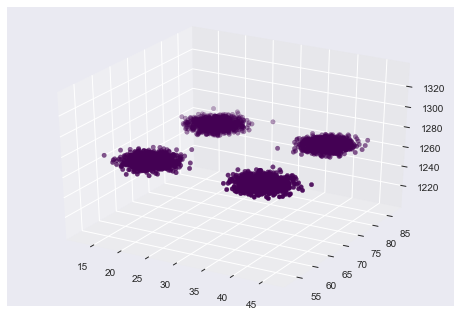

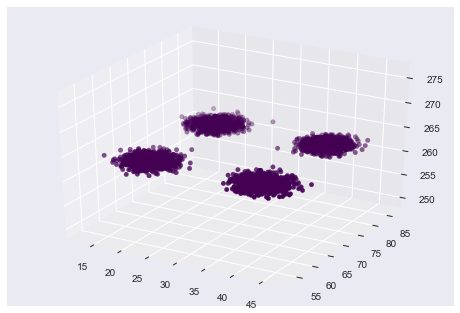

In [25]:
y_mean, y_std = deepensem.predict(X)
plot_data(X, y_mean)
plot_data(X, y_std)

In [26]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_mean, bins=10)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.0
rKL: 0.0
JS: 0.0
